In [1]:
# Libraries
import keras
import tensorflow
from skimage import io
import os
import glob
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from tensorflow.keras import Input,Model
from tensorflow.keras.layers import Flatten

import pickle
from datetime import datetime
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.constraints import unit_norm

from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16

In [2]:
DATASET_PATH = 'dataset/food'

# glob through the directory (returns a list of all file paths)
food_path = os.path.join(DATASET_PATH,  '*')
food_path = glob.glob(food_path)

In [ ]:
# RESHAPE IMAGES

images_dic = {}
for i,path in enumerate(food_path):
    name = path.split("/")[2].split(".")[0]
    image = load_img(food_path[i], target_size=(240, 350))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = preprocess_input(image) # changes depending on the model
    images_dic[name] = image

# save 
with open('imagesdic_vgg.pickle', 'wb') as handle:
    pickle.dump(images_dic, handle, protocol=pickle.HIGHEST_PROTOCOL)

dt_string = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
print("date and time =", dt_string)

In [3]:
# LOAD ALREADY RESHAPED IMAGES
with open("imagesdic_vgg.pickle", "rb") as fp:   # Unpickling
       images_dic = pickle.load(fp)

In [4]:
model = VGG16(include_top=False,input_tensor=Input(shape=(240, 350, 3)))
flat1 = Flatten()(model.layers[-1].output)
model = Model(inputs=model.inputs, outputs=flat1)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 240, 350, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 240, 350, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 240, 350, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 120, 175, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 120, 175, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 120, 175, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 60, 87, 128)       0     

In [5]:
with open('dataset/train_triplets.txt') as f:
    triplets_original = f.readlines()
triplets_original = [line.strip("\n").split(" ") for line in triplets_original]

triplets = []
labels = []
for i,names in enumerate(triplets_original):
    tmp = {}
    tmp['B'] = names[1]
    tmp['C'] = names[2]
    #print(copy)
    l = list(tmp.items())
    random.shuffle(l)
    d = dict(l)
    #print(l)
    triplets.append([names[0],l[0][1],l[1][1]])
    #print(new_lines)
    if d['B'] == l[0][1]:
        labels.append(1.)
    else:
        labels.append(0.)

#save the names of the images in order of appearance! (can be useful)
names_list = []
for triplet in triplets:
    for name in triplet:
        if name not in names_list:
            names_list.append(name)
print("total number of names in the training triplets: ",len(names_list))
print("total number of images: ",len(food_path))



total number of names in the training triplets:  5000
total number of images:  10000


In [ ]:
#COMPUTE FEATURES WITH VGG
#WARNING: takes for ever!!!!!
dt_string = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
print("date and time =", dt_string)

print("total number of images to preprocess: ",len(names_list))
features = {}
for name in names_list:
    features[name] = model.predict(images_dic[name])
    #print(features.shape)

# save
print(features)
with open("features_"+model_name+"_all.pickle", "wb") as fp:   #Pickling
    pickle.dump(features, fp)

dt_string = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
print("date and time =", dt_string)

In [6]:
# Load the features -> takes less time :)
with open("features_vgg_all.pickle", "rb") as fp:   # Unpickling
       features = pickle.load(fp)

In [7]:
# preprocessing for DNN
training_dataset = []

for triplet in triplets:
    tmp = np.hstack(( features[triplet[0]][0], features[triplet[1]][0],features[triplet[2]][0]))
    training_dataset.append(tmp)



In [18]:
# split train and test manually (train_test_split function takes for ever for some reason)

#randomize them together
c = list(zip(training_dataset, labels))
random.shuffle(c)
training_dataset, labels = zip(*c)
print("shuffled")

dt_string = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
print("date and time =", dt_string)

#train and vt samples
train_size = 0.8
X_train = np.array(training_dataset[:int(len(training_dataset)*train_size)])
y_train = np.array(labels[:int(len(labels)*train_size)])

X_vt = np.array(training_dataset[int(len(training_dataset)*train_size):])
y_vt = np.array(labels[int(len(labels)*train_size):])

#validation and test samples
validation_size = 0.5
X_validation = np.array(X_vt[:int(len(X_vt)*validation_size)])
y_validation = np.array(y_vt[:int(len(y_vt)*validation_size)])

X_test = np.array(X_vt[int(len(X_vt)*validation_size):])
y_test = np.array(y_vt[int(len(y_vt)*validation_size):])

dt_string = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
print("date and time =", dt_string)

In [19]:
print(len(X_train),len(X_vt),len(X_validation),len(X_test))

47612 11903 5951 5952


In [27]:
X_train.shape

(47612, 107520)

In [20]:
# Easy Model 

activation = 'relu'
input  = Input((X_train.shape[1],))
layer  = Dense(64, activation=activation   , name='dense1')(input)
layer  = Dense(12, activation=activation   , name='dense2')(layer)
output = Dense(  1, activation='sigmoid', name='output', )(layer)

model = Model(input, output)

model.compile(
  optimizer='adam',
  loss='binary_crossentropy',
  metrics=['acc','mae'],
)

In [23]:
history = model.fit(X_train, y_train,validation_data = (X_validation,y_validation), epochs=40, batch_size=200)

Epoch 1/40
239/239 [==============================] - 33s 136ms/step - loss: 1.2525 - acc: 0.6167 - mae: 0.3947 - val_loss: 1.0268 - val_acc: 0.5940 - val_mae: 0.4192
Epoch 2/40
239/239 [==============================] - 32s 133ms/step - loss: 0.7083 - acc: 0.6790 - mae: 0.3610 - val_loss: 0.8131 - val_acc: 0.6221 - val_mae: 0.4111
Epoch 3/40
239/239 [==============================] - 32s 134ms/step - loss: 0.6159 - acc: 0.7001 - mae: 0.3548 - val_loss: 0.7747 - val_acc: 0.6224 - val_mae: 0.4137
Epoch 4/40
239/239 [==============================] - 32s 134ms/step - loss: 0.5704 - acc: 0.7152 - mae: 0.3521 - val_loss: 0.7530 - val_acc: 0.6239 - val_mae: 0.4112
Epoch 5/40
239/239 [==============================] - 34s 141ms/step - loss: 0.5499 - acc: 0.7267 - mae: 0.3498 - val_loss: 0.7318 - val_acc: 0.6192 - val_mae: 0.4163
Epoch 6/40
239/239 [==============================] - 30s 126ms/step - loss: 0.5410 - acc: 0.7302 - mae: 0.3494 - val_loss: 0.7004 - val_acc: 0.6301 - val_mae: 0.416

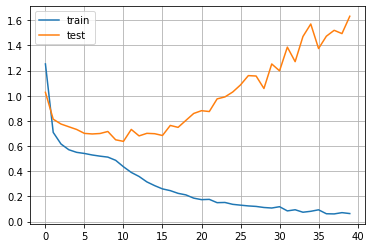

In [24]:
# loss plot
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
# plt.yscale('log')
center = min(history.history['val_loss'] + history.history['loss'])
plt.grid(True)

plt.show()

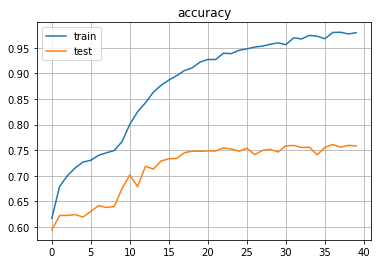

In [25]:
# plot accuracy trends for train and validation sample
plt.title('accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
center = max(history.history['val_acc'] +  history.history['acc'])
# plt.yscale('log')
plt.grid(True)
plt.show()

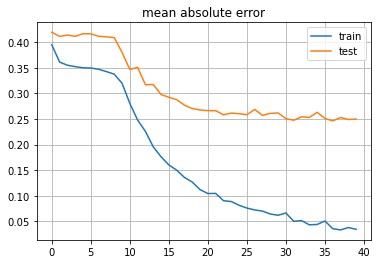

In [26]:
# plot accuracy trends for train and validation sample
plt.title('mean absolute error')
plt.plot(history.history['mae'], label='train')
plt.plot(history.history['val_mae'], label='test')
plt.legend()
center = min(history.history['val_mae'] + history.history['mae'])
# plt.yscale('log')
plt.grid(True)

plt.show()



In [ ]:
y_pred = model.predict(X_validation_one_hot)